# Exploratory Data Analysis
This notebook will explore the cleaned dataset from <a href="https://www.gunviolencearchive.org/mass-shooting">Gun Violence Archive</a>

In [24]:
# import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import datetime

# visulaztion packages
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# import pickled data
df_gun = pd.read_pickle("./data/pickle/df_gun_violence")

# preview
df_gun.head()

,incident_id,incident_date,state,city_or_county,address,#_killed,#_injured
0,2478664,2022-12-11,Illinois,Chicago,5500 block of W School St,3,1
1,2478061,2022-12-09,Arizona,Phoenix,S 21st and W Burgess LN,1,3
2,2477622,2022-12-08,Michigan,Detroit,1114 Washington Blvd,0,4
3,2477404,2022-12-08,Louisiana,New Orleans,4242 Chef Menteur Hwy,0,4
4,2475554,2022-12-06,New York,Bronx,Daly Ave and E 180th St,0,4


## Summary Statistics

In [26]:
df_gun.describe()

,incident_id,#_killed,#_injured
count,2.000000e+03,2000.000000,2000.000000
mean,2.033979e+06,0.976000,4.149500
std,2.654732e+05,1.389744,2.188274
min,1.535478e+06,0.000000,0.000000
25%,1.786823e+06,0.000000,3.000000
50%,2.050260e+06,1.000000,4.000000
75%,2.274785e+06,1.000000,5.000000
max,2.478664e+06,22.000000,29.000000


As expected, looks like `#_injured` is more common than `#_killed` by almost 4:1 ratio on average per mass shooting. **Standard deviation** of `#_killed` is pretty significantly smaller than `#_injured` suggesting it deosn't vary that much, in fact the 75th percentile is only 1. This tells us the **Max** of 22 is extremely rare. I wonder what the statistical likiehood of that event happening. Perhaps this is something I can explore.

## Exploratory Plots

### Histograms

In [27]:
# histogram function
def hist_func(df, col, title, xlabel):
    """
    Provide df and column xlabel and title 
    to produce histogram
    """
    sns.histplot(df[col], binwidth=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

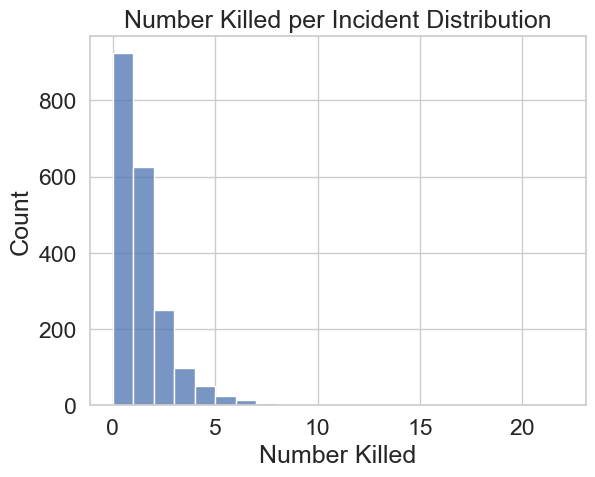

In [28]:
# histogram killed
hist_func(df_gun, "#_killed", "Number Killed per Incident Distribution", "Number Killed")

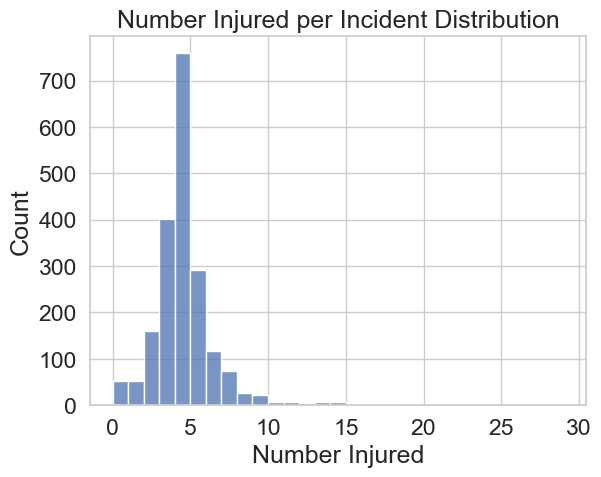

In [29]:
# histogram injured
hist_func(df_gun, "#_injured", "Number Injured per Incident Distribution", "Number Injured")

We can see that `#_injured` is much more normal than `#_killed`, however there are still some outliers in `#_injured`.
<br>
`#_killed` is right-skewed.
<br>
4 is the most common amount for those injured.

### Boxplots

In [30]:
# melt to utilize catplot
df_gun_melt = df_gun.melt(
    id_vars=['incident_id', 'incident_date', 'state', 'city_or_county', 'address'])

# preview
df_gun_melt.head()

,incident_id,incident_date,state,city_or_county,address,variable,value
0,2478664,2022-12-11,Illinois,Chicago,5500 block of W School St,#_killed,3
1,2478061,2022-12-09,Arizona,Phoenix,S 21st and W Burgess LN,#_killed,1
2,2477622,2022-12-08,Michigan,Detroit,1114 Washington Blvd,#_killed,0
3,2477404,2022-12-08,Louisiana,New Orleans,4242 Chef Menteur Hwy,#_killed,0
4,2475554,2022-12-06,New York,Bronx,Daly Ave and E 180th St,#_killed,0


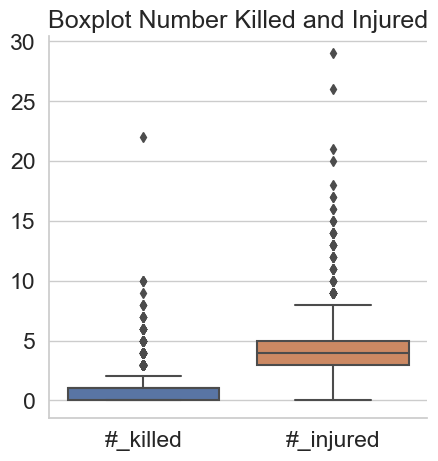

In [31]:
# boxplot
sns.catplot(data=df_gun_melt,kind="box",
           x="variable", y="value")
plt.title("Boxplot Number Killed and Injured")
plt.ylabel("")
plt.xlabel("")
plt.show()

### Scatterplot
Let's take a look at the relationship of killed vs. injured

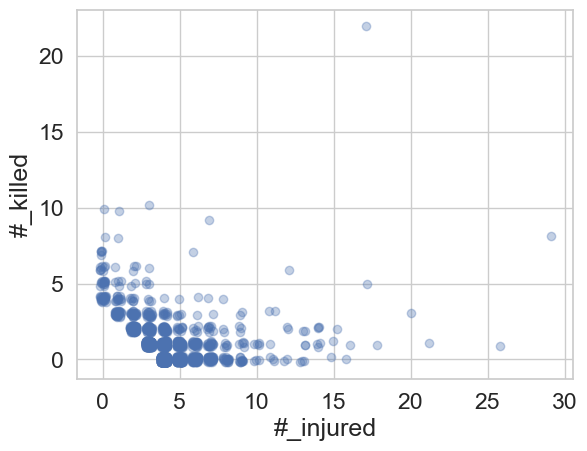

In [32]:
# scatterplot
sns.regplot(data=df_gun,
            x="#_injured",
            y="#_killed", 
            fit_reg=False,
            x_jitter=0.2,
            y_jitter=0.2,
            scatter_kws = {'alpha' : 1/3})
plt.show()

Looks like there is a negative relationship between `#_injured` and `#_killed`.

### State Exploration
Let's look at which states have the most mass shootings.<br>
We will need to bring in some census data soon so that we can compare this in ratio as opposed to pure amount. Some states have higher population then others, therefore 

In [33]:
# first sum up each column
tot_injured = df_gun["#_injured"].sum()
tot_killed = df_gun["#_killed"].sum()

print("Number injured:", tot_injured)
print("Number killed:", tot_killed)
print("Ratio of killed to injured", round(tot_killed/tot_injured,2))

Number injured: 8299
Number killed: 1952
Ratio of killed to injured 0.24


In [34]:
# create group_mult function
# groupby func
def groupby_mult(df, groupby_list, agg_dict, sort_list):
    """
    Pass df, groupby list and agg dict, sort order list
    Will return new df
    """
    df_grouped = df.groupby(groupby_list).agg(agg_dict)\
    .sort_values(by=sort_list,ascending=False).reset_index()
    return df_grouped

In [35]:
# state killed
df_state_killed = groupby_mult(df_gun,"state",{"#_killed":"sum"},"#_killed")
# state injured
df_state_injured = groupby_mult(df_gun,"state",{"#_injured":"sum"},"#_injured")

In [36]:
#top 5
print(df_state_injured.head())
print("\n")
print(df_state_killed.head())

        state  #_injured
0    Illinois        963
1       Texas        584
2  California        559
3    New York        455
4     Florida        434


        state  #_killed
0       Texas       200
1  California       179
2    Illinois       153
3     Florida        84
4     Georgia        78


In [37]:
# function for bar plot
def bar_horiz(df, colx, coly, xlabel, title, ylabel = "",
              figsize=(14,12), titlesize=20, palette = "Blues"):
    """
    Plots horizontal bar chart.
    Pass df, x, y, xlabel, title
    Defaults ylabel = "", figsize, titlesize and palette
    """
    sns.set_theme(context="notebook", 
                  style="whitegrid",
                 font_scale=1.5)
    palette = sns.color_palette(palette, n_colors=df[coly].count())
    palette.reverse()
    plt.figure(figsize=figsize)
    sns.barplot(data=df,
                x=df[colx],
                y=df[coly],
                orient="h",
               palette=palette)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=titlesize)
    plt.show()

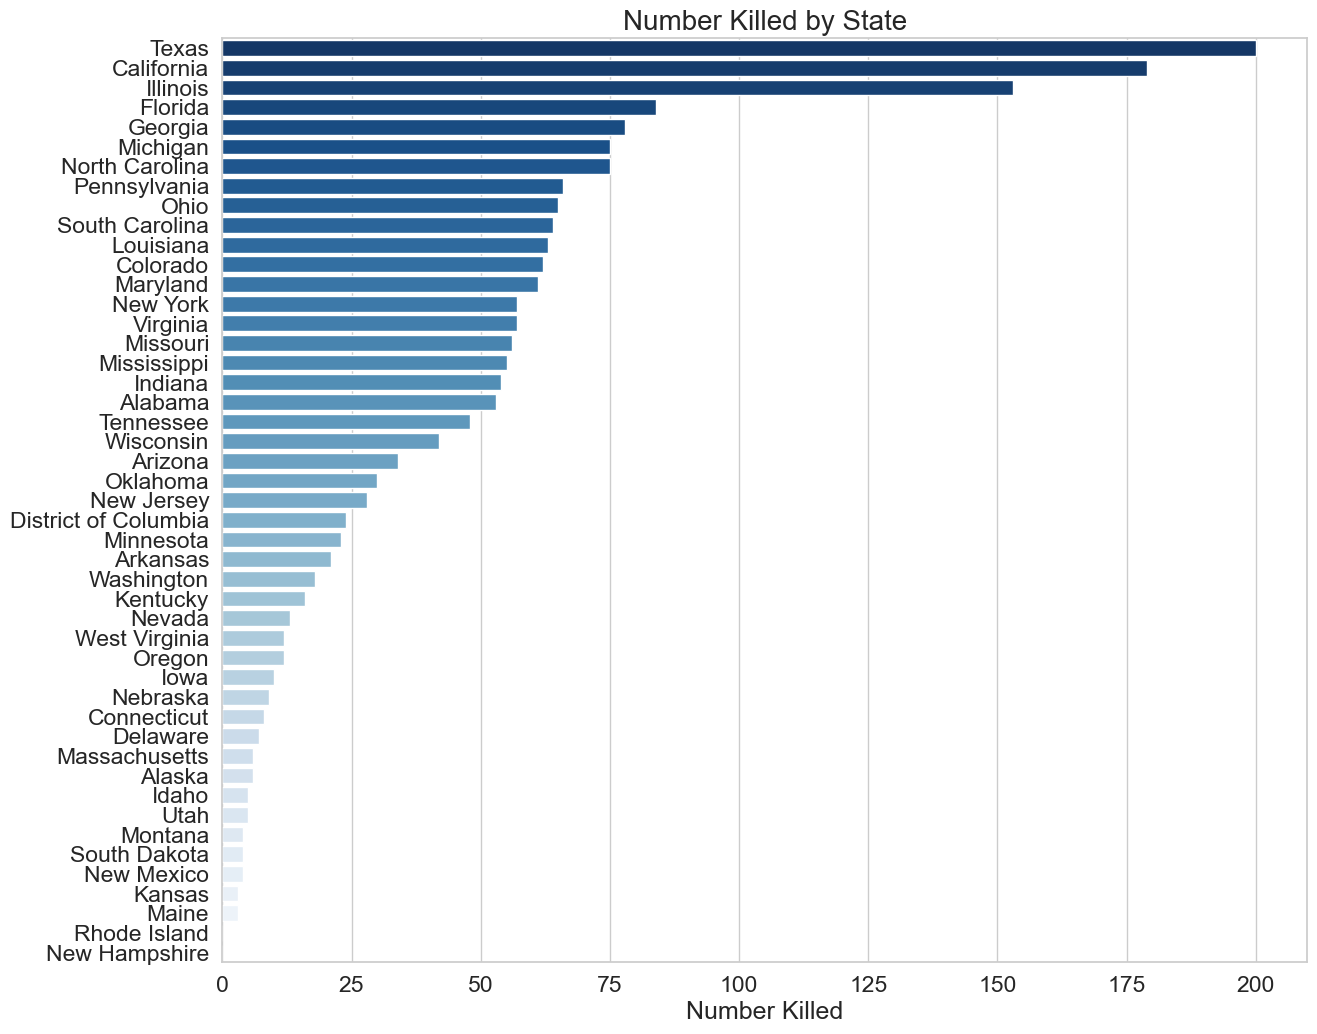

In [38]:
bar_horiz(df=df_state_killed, colx="#_killed",
          coly="state",xlabel="Number Killed", title="Number Killed by State")

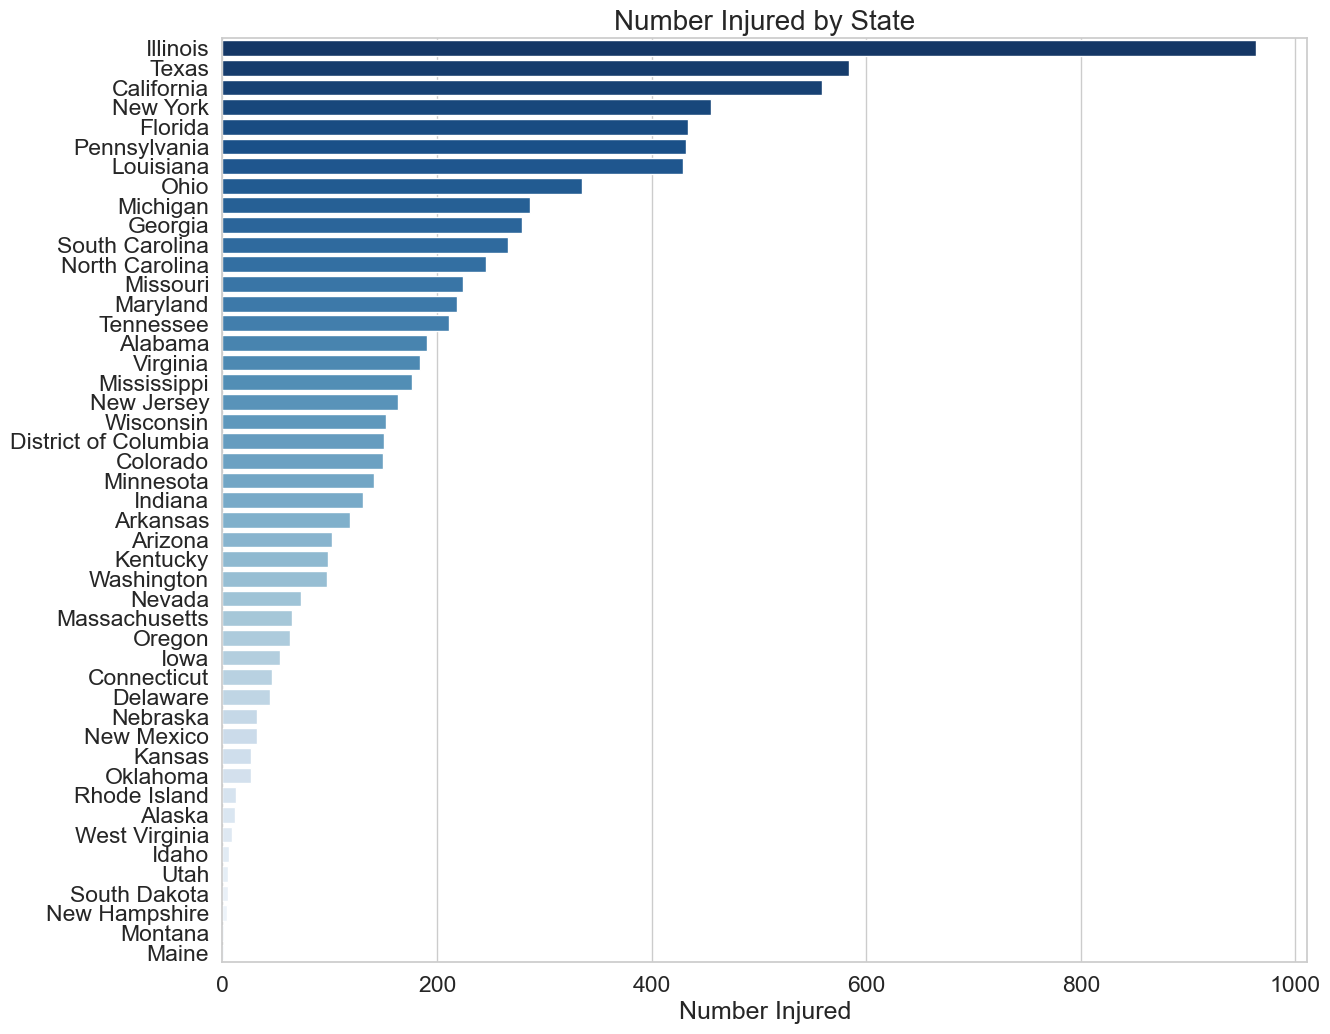

In [39]:
bar_horiz(df_state_injured, "#_injured", "state","Number Injured", "Number Injured by State")

This plot would be interesting as a map as well.<br>
Also compare top 5.

Well what if we normalize the states to compare by `#_injured` and `#_killed` by ratio of events happening within each state.<br>
So, per event, how many are injured and how many are killed.

In [40]:
# create variables for function
groupby_list = ["state"]
agg_dict = {"#_injured":"sum","#_killed":"sum","incident_id":"count"}
sort_list = ["incident_id","#_injured","#_killed"]
rename_dict = {"incident_id":"count"}

# apply function
df_state_grouped = groupby_mult(df_gun, groupby_list, agg_dict, sort_list)

# preview result
df_state_grouped.head()

,state,#_injured,#_killed,incident_id
0,Illinois,963,153,214
1,Texas,584,200,146
2,California,559,179,145
3,New York,455,57,104
4,Pennsylvania,432,66,104


In [41]:
# rename incident_id col
df_state_grouped.rename(columns={"incident_id":"count"}, inplace=True)

In [42]:
# create total injured/killed column per state
df_state_grouped["total_injured_killed"] = \
df_state_grouped["#_killed"] + df_state_grouped["#_injured"]

Now need to create ratio columns

In [43]:
# function to create ratio columns
def ratio_func(df,col1_list,col2_list,new_col_list):
    """
    This function will create a new column that is a ratio of col1 / col2
    Pass list of cols to create multiple ratio cols simultaneously
    """
    for (col1, col2, new_col) in zip(col1_list, col2_list, new_col_list):
        df[new_col] = round(df[col1] / df[col2],2)

In [44]:
# set variables for function
col1_list = ["#_killed", "#_injured", "total_injured_killed"]
col2_list = ["count","count","count"]
new_col_list = ["killed_by_incident", "injured_by_incident", "total_by_incident"]


# killed by incident
ratio_func(df_state_grouped,col1_list, col2_list, new_col_list)

In [45]:
# preview results ratio columns
df_state_grouped.sort_values(by="killed_by_incident", ascending=False).head()

,state,#_injured,#_killed,count,total_injured_killed,killed_by_incident,injured_by_incident,total_by_incident
45,Montana,1,4,1,5,4.00,1.00,5.00
46,Maine,1,3,1,4,3.00,1.00,4.00
39,West Virginia,9,12,4,21,3.00,2.25,5.25
34,Oklahoma,27,30,11,57,2.73,2.45,5.18
42,Utah,5,5,2,10,2.50,2.50,5.00


I have to control by population per 100k otherwise these ratios do not make much sense.

#### Per 100k population

In order to make compare these events fairly between states, we need to normalize the incidents by 100k. Bring in census data to with population figures to calculate this number.

In [46]:
# load census data w/o shp first to get numbers correct
df_census = pd.read_pickle("./data/pickle/df_us_census")

# preview df
df_census.head()

,state,population,state_fips
0,Pennsylvania,12794885.0,42
1,California,39346023.0,06
2,West Virginia,1807426.0,54
3,Utah,3151239.0,49
4,New York,19514849.0,36


In [47]:
# join state grouped df with census data
df_state_census = df_state_grouped.merge(df_census)

# preview
df_state_census.head()

,state,#_injured,#_killed,count,total_injured_killed,killed_by_incident,injured_by_incident,total_by_incident,population,state_fips
0,Illinois,963,153,214,1116,0.71,4.50,5.21,12716164.0,17
1,Texas,584,200,146,784,1.37,4.00,5.37,28635442.0,48
2,California,559,179,145,738,1.23,3.86,5.09,39346023.0,06
3,New York,455,57,104,512,0.55,4.38,4.92,19514849.0,36
4,Pennsylvania,432,66,104,498,0.63,4.15,4.79,12794885.0,42


Create function to do per 100k calculations. 
<br>
Will need the following calculations:
- pop/1k
- count/(pop/1k)
- injured/(pop/1k)
- killed/(pop/1k)
- total/(pop/1k)

In [48]:
# function to create rate per 1k columns
def rate_per_1k(df, col_list, new_col_list, pop="population"):
    """
    Pass df, column list and new column name list to function.
    Will create new rate per 1k population columns for those passed
    """
    df["pop_per_1k"] = round(df[pop] / 1000)
    for (col,new_col) in zip(col_list, new_col_list):
        df[new_col] = round(df[col] / df["pop_per_1k"] * 100,2)

In [49]:
# create lists for function
col_list = ["count","#_injured", "#_killed", "total_injured_killed"]
new_col_list = ["count_per_1k", "injured_per_1k","killed_per_1k","total_per_1k"]

# pass to function
rate_per_1k(df_state_census, col_list, new_col_list)

In [50]:
# preview
df_state_census.sort_values(by="pop_per_1k", ascending=False).head(6)

,state,#_injured,#_killed,count,total_injured_killed,killed_by_incident,injured_by_incident,total_by_incident,population,state_fips,pop_per_1k,count_per_1k,injured_per_1k,killed_per_1k,total_per_1k
2,California,559,179,145,738,1.23,3.86,5.09,39346023.0,06,39346.0,0.37,1.42,0.45,1.88
1,Texas,584,200,146,784,1.37,4.00,5.37,28635442.0,48,28635.0,0.51,2.04,0.70,2.74
5,Florida,434,84,99,518,0.85,4.38,5.23,21216924.0,12,21217.0,0.47,2.05,0.40,2.44
3,New York,455,57,104,512,0.55,4.38,4.92,19514849.0,36,19515.0,0.53,2.33,0.29,2.62
4,Pennsylvania,432,66,104,498,0.63,4.15,4.79,12794885.0,42,12795.0,0.81,3.38,0.52,3.89
0,Illinois,963,153,214,1116,0.71,4.50,5.21,12716164.0,17,12716.0,1.68,7.57,1.20,8.78


Construct Top 10 grouped bar charts based on different per 1k statistics.
Will need to melt some df columns to utilize sns.catplot()

In [51]:
# restrict df to only rates per 1k, population, state_fips and state column
df_per_1k = df_state_census[['state','population', 'state_fips', 'pop_per_1k', 'count_per_1k',
       'injured_per_1k', 'killed_per_1k', 'total_per_1k']]

# preview
df_per_1k.head()

,state,population,state_fips,pop_per_1k,count_per_1k,injured_per_1k,killed_per_1k,total_per_1k
0,Illinois,12716164.0,17,12716.0,1.68,7.57,1.20,8.78
1,Texas,28635442.0,48,28635.0,0.51,2.04,0.70,2.74
2,California,39346023.0,06,39346.0,0.37,1.42,0.45,1.88
3,New York,19514849.0,36,19515.0,0.53,2.33,0.29,2.62
4,Pennsylvania,12794885.0,42,12795.0,0.81,3.38,0.52,3.89


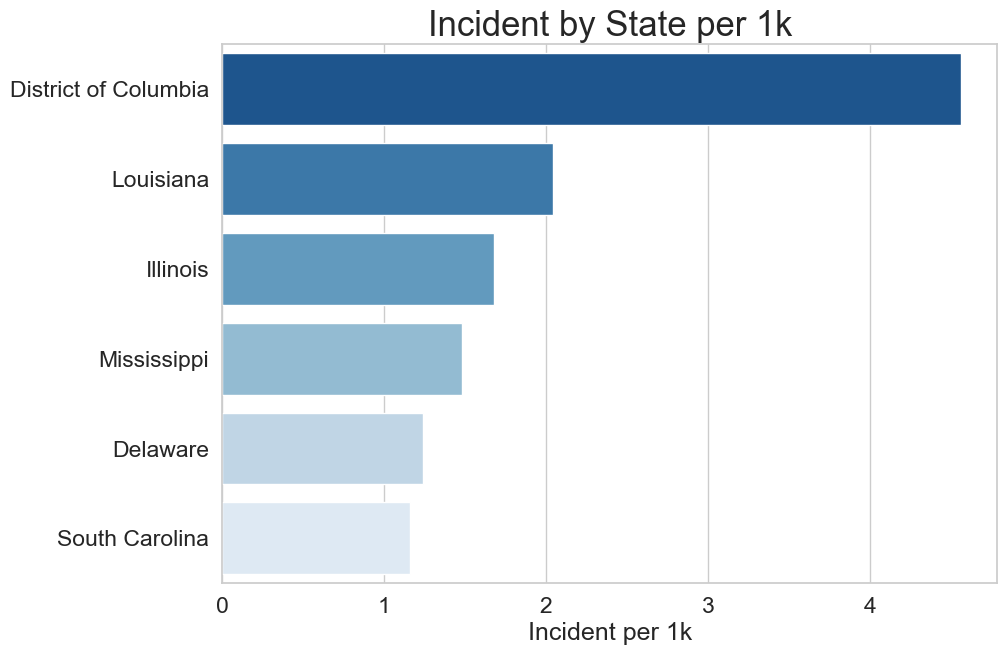

In [52]:
# top N count per 1k
bar_horiz(df_per_1k.sort_values(by="count_per_1k",ascending=False).head(6),
         colx="count_per_1k",
         coly="state",
         xlabel="Incident per 1k",
         title="Incident by State per 1k",
         titlesize=25,
         figsize=(10,7))

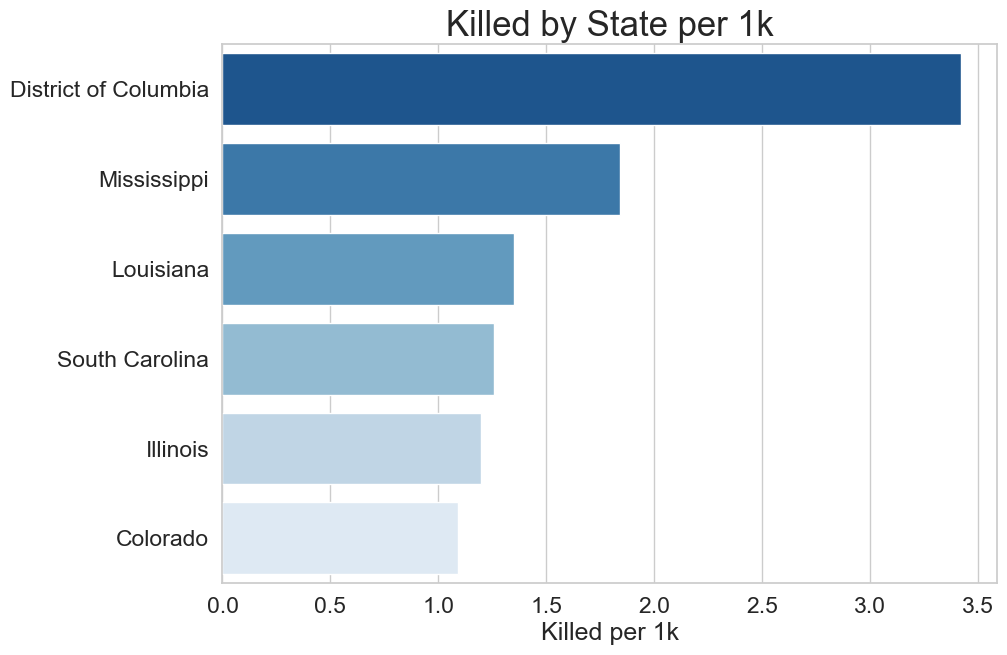

In [53]:
# top N killed per 1k
bar_horiz(df_per_1k.sort_values(by="killed_per_1k",ascending=False).head(6),
         colx="killed_per_1k",
         coly="state",
         xlabel="Killed per 1k",
         title="Killed by State per 1k",
         titlesize=25,
         figsize=(10,7))

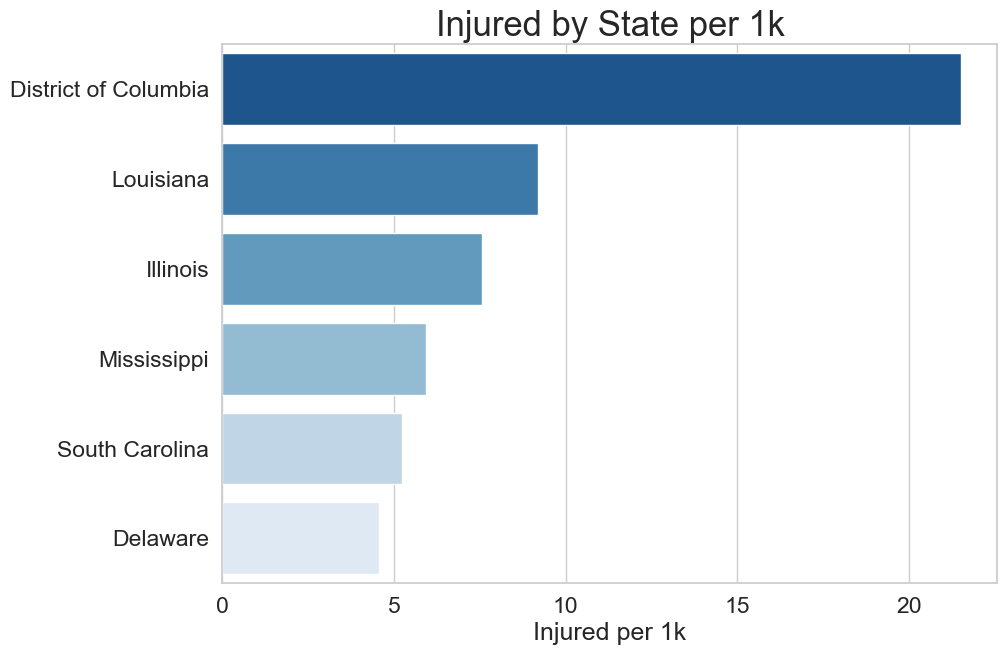

In [54]:
# top N injured per 1k
bar_horiz(df_per_1k.sort_values(by="injured_per_1k",ascending=False).head(6),
         colx="injured_per_1k",
         coly="state",
         xlabel="Injured per 1k",
         title="Injured by State per 1k",
         titlesize=25,
         figsize=(10,7))

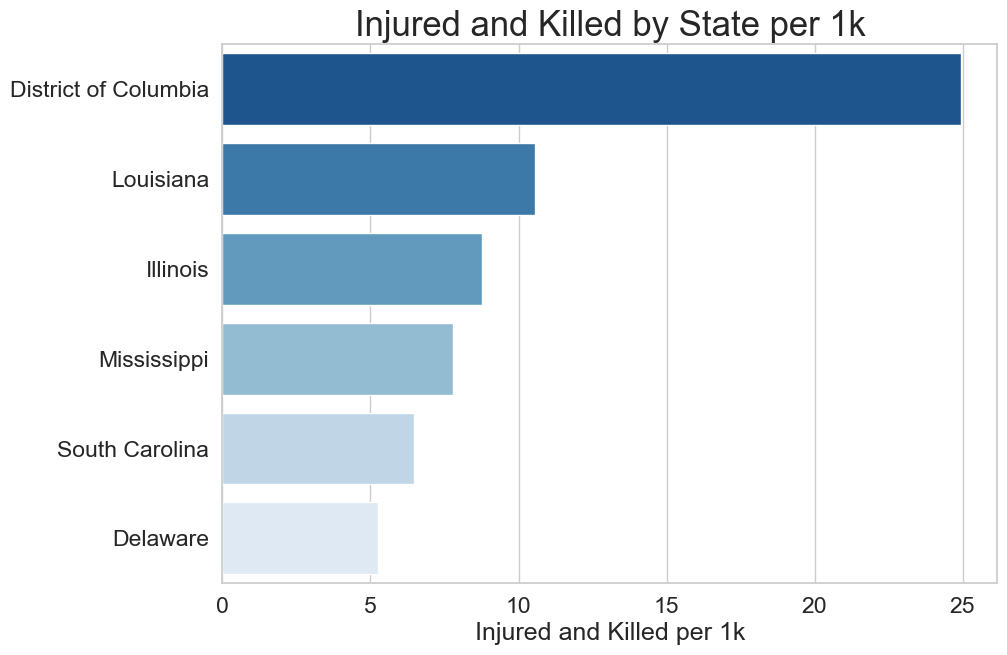

In [55]:
# top N total injured and killed per 1k
bar_horiz(df_per_1k.sort_values(by="total_per_1k",ascending=False).head(6),
         colx="total_per_1k",
         coly="state",
         xlabel="Injured and Killed per 1k",
         title="Injured and Killed by State per 1k",
         titlesize=25,
         figsize=(10,7))

### Mapping

Let's map a few maps that showcase different per 1k aspects geographically.

In [56]:
# import shapefile
us_shp = gpd.GeoDataFrame(pd.read_pickle("./data/pickle/us_census_shp"))

In [62]:
# join with us_census df
df_per_1k_gpd = gpd.GeoDataFrame(df_per_1k.merge(us_shp))

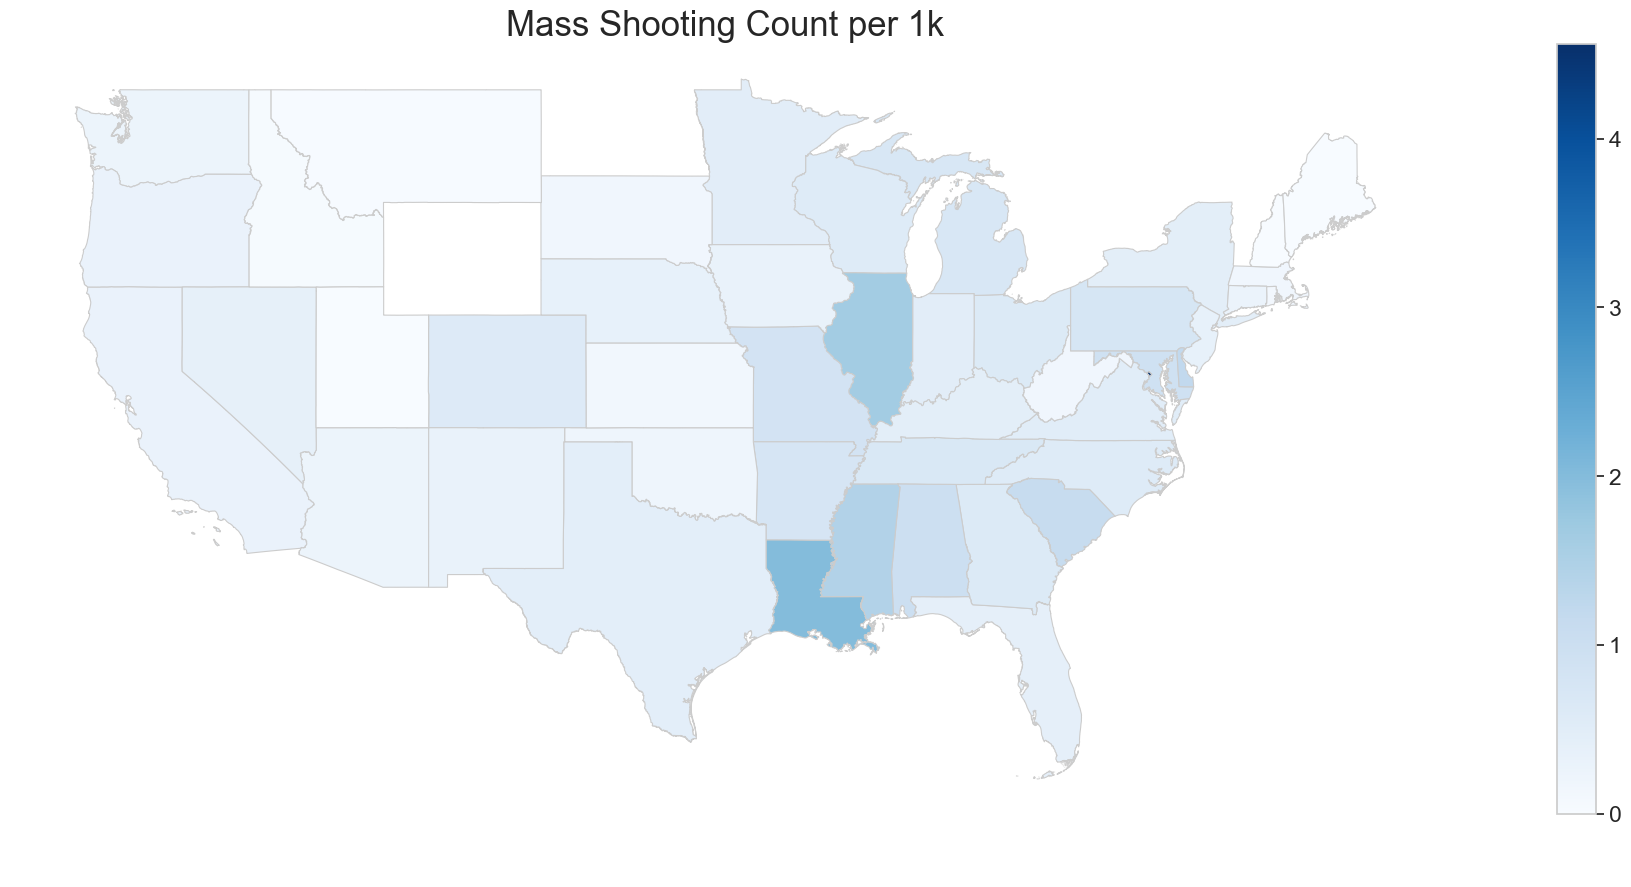

In [71]:
# set the value column that will be visualised
variable = 'count_per_1k'
# set the range for the choropleth values
vmin, vmax = 0, max(df_per_1k_gpd["count_per_1k"])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Mass Shooting Count per 1k', 
             fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: Gun Violence Archive - https://www.gunviolencearchive.org', 
            xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', 
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)
# create map
df_per_1k_gpd.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.show()

### Date exploration

What if we looked at date, creating a month and year column and then look at when the most mass shootings happened?

In [227]:
# function to create day, month, year, weekday and day name from date column
def date_column(df, datecol):
    """
    Pass datetime column and crate new cols in df:
    - day, month, year, weekday, dayname
    """
    if pd.api.types.is_datetime64_dtype(df[datecol]):
        df["day"] = df[datecol].dt.day
        df["month"] = df[datecol].dt.month
        df["year"] = df[datecol].dt.year
        df["dayofweek"] = df[datecol].dt.weekday
        df["dayname"] = df[datecol].dt.day_name()
        df["daytype"] = np.where(df["dayofweek"] >= 5,"Weekend","Weekday")
    else:
        print("Please pass datetime column")

In [233]:
# create date cols
date_column(df_gun, "incident_date")

In [234]:
# preview result
df_gun.head()

,incident_id,incident_date,state,city_or_county,address,#_killed,#_injured,day,month,year,dayofweek,dayname,weekend,daytype
0,2478664,2022-12-11,Illinois,Chicago,5500 block of W School St,3,1,11,12,2022,6,Sunday,Yes,Weekend
1,2478061,2022-12-09,Arizona,Phoenix,S 21st and W Burgess LN,1,3,9,12,2022,4,Friday,No,Weekday
2,2477622,2022-12-08,Michigan,Detroit,1114 Washington Blvd,0,4,8,12,2022,3,Thursday,No,Weekday
3,2477404,2022-12-08,Louisiana,New Orleans,4242 Chef Menteur Hwy,0,4,8,12,2022,3,Thursday,No,Weekday
4,2475554,2022-12-06,New York,Bronx,Daly Ave and E 180th St,0,4,6,12,2022,1,Tuesday,No,Weekday


Groupby day, count, killed and injured

In [236]:
# create variables for groupby func
groupby_list = ["dayname", "daytype"]
agg_dict = {"#_injured":"sum","#_killed":"sum","incident_id":"count"}
sort_order = ["incident_id","#_injured","#_killed"]

# apply function
df_day_grouped = groupby_mult(df_gun, groupby_list, agg_dict, sort_order)

# preview results
df_day_grouped

,dayname,daytype,#_injured,#_killed,incident_id
0,Sunday,Weekend,2468,540,566
1,Saturday,Weekend,2085,414,475
2,Friday,Weekday,907,212,230
3,Wednesday,Weekday,686,204,194
4,Monday,Weekday,799,177,190
5,Thursday,Weekday,698,184,178
6,Tuesday,Weekday,656,221,167


In [237]:
# rename incident_id col to count
df_day_grouped.rename(columns={"incident_id":"count"}, inplace=True)

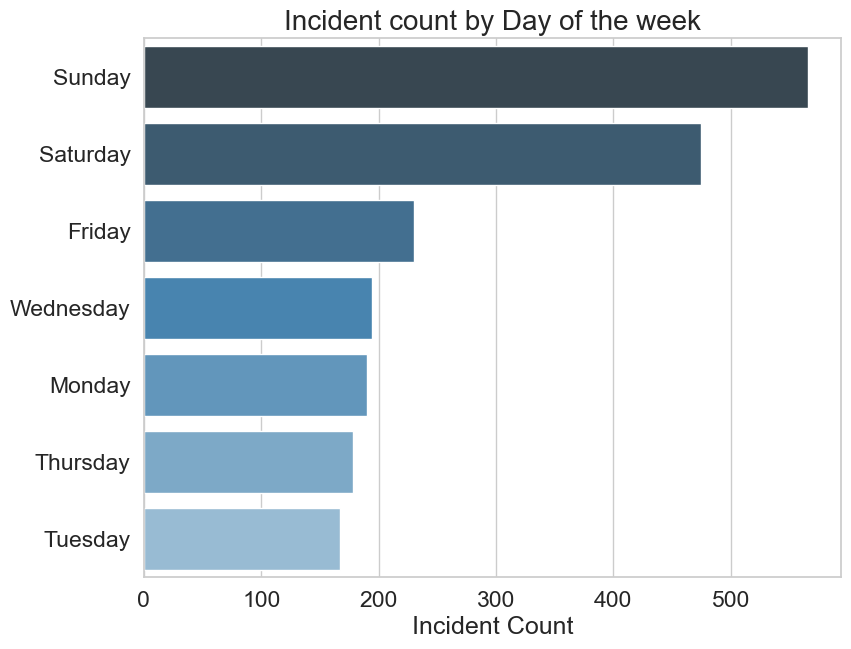

In [238]:
# plot total
bar_horiz(df_day_grouped, "count", "dayname", 
          "Incident Count", "Incident count by Day of the week", figsize=(9,7),
         palette="Blues_d")

Let's look ratio of `#_killed` and `#_injured` per day.

In [239]:
# create total injured/killed column per day
df_day_grouped["total_injured_killed"] = \
df_day_grouped["#_killed"] + df_day_grouped["#_injured"]

In [240]:
# set variables for function
col1_list = ["#_killed", "#_injured", "total_injured_killed"]
col2_list = ["count","count","count"]
new_col_list = ["killed_by_incident", "injured_by_incident", "total_by_incident"]


# killed by incident
ratio_func(df_day_grouped,col1_list, col2_list, new_col_list)

In [241]:
df_day_grouped

,dayname,daytype,#_injured,#_killed,count,total_injured_killed,killed_by_incident,injured_by_incident,total_by_incident
0,Sunday,Weekend,2468,540,566,3008,0.95,4.36,5.31
1,Saturday,Weekend,2085,414,475,2499,0.87,4.39,5.26
2,Friday,Weekday,907,212,230,1119,0.92,3.94,4.87
3,Wednesday,Weekday,686,204,194,890,1.05,3.54,4.59
4,Monday,Weekday,799,177,190,976,0.93,4.21,5.14
5,Thursday,Weekday,698,184,178,882,1.03,3.92,4.96
6,Tuesday,Weekday,656,221,167,877,1.32,3.93,5.25


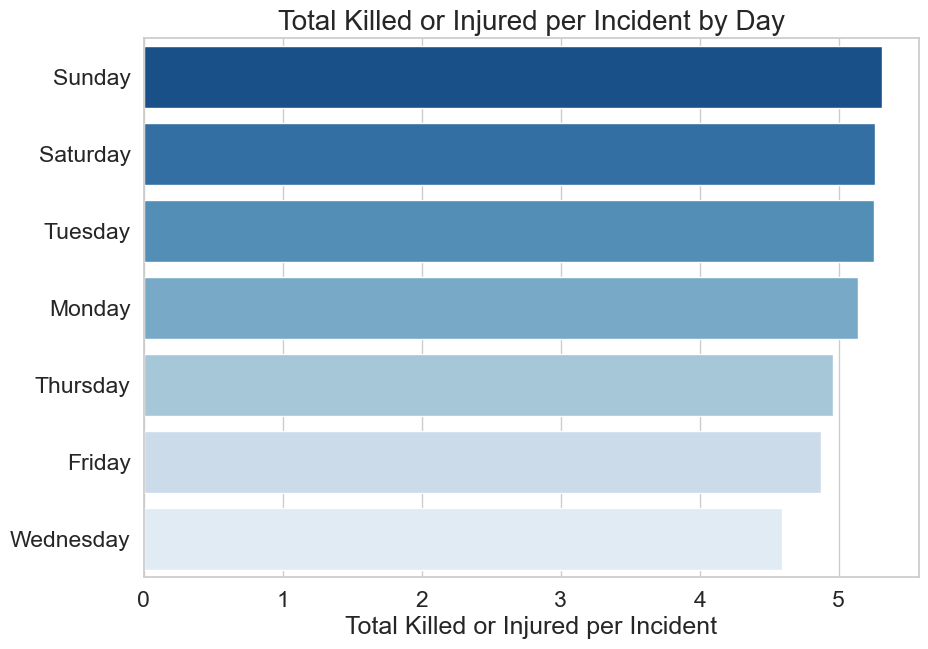

In [242]:
# weekday total per incident per day
bar_horiz(df_day_grouped.sort_values(by="total_by_incident",ascending=False),
          colx="total_by_incident",coly="dayname",
          xlabel="Total Killed or Injured per Incident",
          title="Total Killed or Injured per Incident by Day",
          figsize=(10,7))

So Sunday and Saturday have the most incidents per day, and they also have the highest ratio of `#_killed` and `#_injured` per incident. Interestingly, Tuesday is 3rd in ratio, whilst last in incident count, suggesting when mass shootings happen on Tuesday, they tend to have more injuries and casualties then any other weekday.
<br><br>
In fact, let's look at weekend day vs. weekday to see how drastic the comparision is.

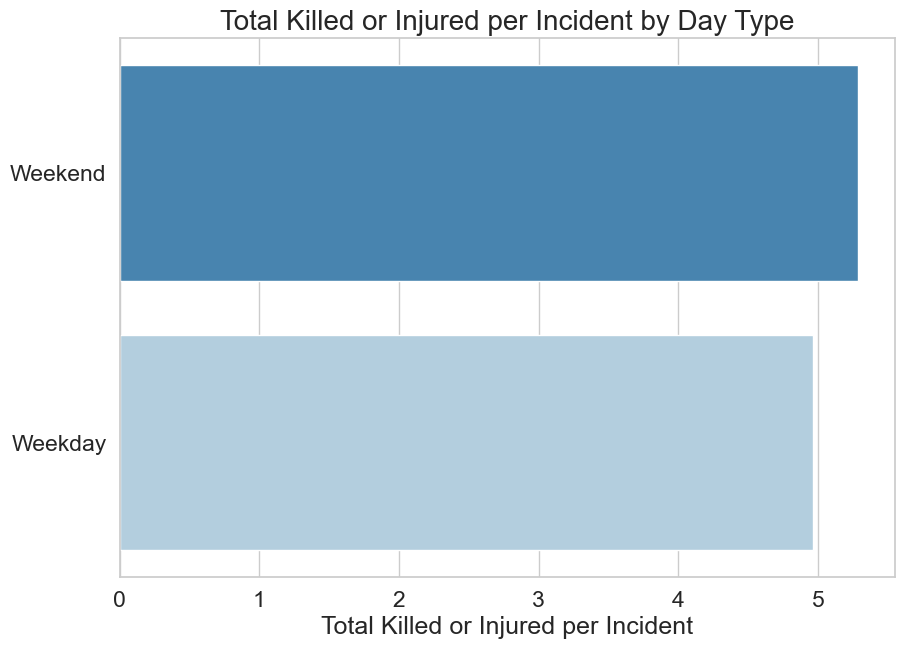

In [247]:
# weekend vs. weekday per incident per day
bar_horiz(pd.DataFrame(df_day_grouped.groupby("daytype", 
                                              as_index=False)["total_by_incident"]\
                       .mean()).sort_values(by="total_by_incident",ascending=False),
          colx="total_by_incident",coly="daytype",
          xlabel="Total Killed or Injured per Incident",
          title="Total Killed or Injured per Incident by Day Type",
          figsize=(10,7))

Can see the ratio of `#_killed` and `#_injured` for weekends is slightly higher the weekdays overall, telling us that not only are there more incidents on Weekends vs. Weekdays, but that they have more injuries and casualties. That said, it isn't that drastic of a difference, slightly over 5 for Weekends and slightly under 5 for Weekdays.